# Bayesian Neural Networks with Latent Variables

## Theoretic Foundation

BNN with latent variables (LVs) extend BNNs with VI to encompass LVs that model aleatoric uncertainty. The BNN+LV model is proposed in [Depeweg, 2018](http://proceedings.mlr.press/v80/depeweg18a/depeweg18a.pdf). 

The likelihood is given by
$$
p(Y |\theta,z ,X) =
\prod_{i=1}^K p(y_i|\theta,z_i,x_i) =
\prod_{i=1}^K \mathcal{N}(y_{i} | f_{\theta}(x_i,z_i), \Sigma).
$$

The prior on the weights is obtained as for BNNs with VI and is given by,

$$
    p(\theta) = \prod_{l=1}^L \prod_{h=1}^{V_l }\prod_{j=1}^{V_{l-1}+1} \mathcal{N}(w_{hj, l} \vert 0, \lambda)
$$
where $w_{hj, l}$ is the h-th row and the j-th column of weight matrix $\theta_L$ at layer index $L$ and $\lambda$ is the prior variance. Note that as we use partially stochastic networks, the above may contain less factors $\mathcal{N}(w_{hj, l} \vert 0, \lambda)$ depending on how many layers are stochastic. The prior distribution of the latent variables z is given by

$$
    p(z)=\prod_{i=1}^K \mathcal{N}(z_i \vert 0, \gamma)
$$
where $\gamma$ is the prior variance.

Then, with the assumed likelihood function and prior, a posterior over the
weights $\theta$ and latent variables $z$ is obtained via Bayes' rule:
$$
p(\theta,z|\mathcal{D}) = \frac{p(Y|\theta,z,X)
p(\theta)p(z)}
{p(Y|X)}
$$

The approximate the posterior is given by

$$
q(\theta,z) =  \underbrace{\left[ \prod_{l=1}^L\! \prod_{h=1}^{V_l}\!  \prod_{j=1}^{V_{l\!-\!1}\!+\!1} \mathcal{N}(w_{hj,l}\vert m^w_{hj,l},v^w_{hj,l})\right]}_{\text{\small $q(\theta)$}} \times
\underbrace{\left[\prod_{i=1}^K \mathcal{N}(z_i \vert m_i^z, v_i^z) \right]}_{\text{\small $q(\mathbf{z})$}}.
$$

Now the parameters $m^w_{hj,l}$,$v^w_{hj,l}$ and $m^z_i$, $v^z_i$ can be obtained
by minimizing a divergence between $p(\theta, z| \mathcal{D})$. Here the following approximation of the $\alpha$ divergence, as proposed in [Lobato, 2016](http://proceedings.mlr.press/v48/hernandez-lobatob16.pdf) and [Depeweg, 2016](https://arxiv.org/abs/1605.07127), is used,


$$
E_\alpha(q) = -\log Z_q - \frac{1}{\alpha} \sum_{n=1}^N
\log \mathbf{E}_{\Theta,z_n\sim\, q}\left[ \left( \frac{p(\mathbf{y}_n | \Theta, \mathbf{x}_n, z_n, \mathbf{\Sigma)}}
{f(\Theta)f_n(z_n)}\right)^\alpha \right],
$$

where $Z_n$ is the normalising constant of the exponential form of approximate the posterior and $f(\Theta)$ and $f_n(z_n)$ are functions depending on the parameters of the distributions of the prior on the weights and of the prior distribution of the latent variables, see [Depeweg, 2016](https://arxiv.org/abs/1605.07127) for details. In order to make this optimization problem scalable, SGD is used with mini-batches, and the expectation over $q$ is approximated with an average over $K$ samples drawn from $q$.

The posterior predictive distribution is given by,
$$
    p(y_{\star}\vert x_{\star}, \mathcal{D}) = \int  \left[\int \mathcal{N}(y_{\star} \vert f_{\theta}(x_{\star}, z_{\star}),  \Sigma) \mathcal{N}(z_{\star} \vert 0, \gamma) dz_{\star} \right] p(\theta, z \vert \mathcal{D}) d\theta dz.
$$

The network prediction $f_{\theta}(x_{\star}, z_{\star})$ uses $z_{\star}$ sampled from the prior distribution $\mathcal{N}(z_{\star} \vert 0, \gamma)$ because this is the only evidence we have about the latent variable for a new data point since all data points are assumed to be independent. However, the above posterior predictive distribution is intractable in this form. So instead we use sampling from the posterior distribution of the weights. The mean prediction is then given by the mean prediction of samples and the predictive uncertainty is obtained as standard deviation of samples from the approximation to the posterior predictive distribution.


## Imports

In [1]:
import os
import sys

import tempfile
import torch
from functools import partial

import matplotlib.pyplot as plt
import torch.nn as nn
from lightning import Trainer
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import CSVLogger

from lightning_uq_box.datamodules import ToyHeteroscedasticDatamodule
from lightning_uq_box.models import MLP
from lightning_uq_box.uq_methods import BNN_LV_VI_Batched_Regression
from lightning_uq_box.viz_utils import (
    plot_calibration_uq_toolbox,
    plot_predictions_regression,
    plot_toy_regression_data,
    plot_training_metrics,
)

plt.rcParams["figure.figsize"] = [14, 5]

In [2]:
seed_everything(0)  # seed everything for reproducibility

Seed set to 0


0

We define a temporary directory to look at some training metrics and results.

In [3]:
my_temp_dir = tempfile.mkdtemp()

## Datamodule

To demonstrate the method, we will make use of a Toy Regression Example that is defined as a [Lightning Datamodule](https://lightning.ai/docs/pytorch/stable/data/datamodule.html). While this might seem like overkill for a small toy problem, we think it is more helpful how the individual pieces of the library fit together so you can train models on more complex tasks.

In [4]:
dm = ToyHeteroscedasticDatamodule(batch_size=50)

X_train, y_train, train_loader, X_test, y_test, test_loader = (
    dm.X_train,
    dm.y_train,
    dm.train_dataloader(),
    dm.X_test,
    dm.y_test,
    dm.test_dataloader(),
)

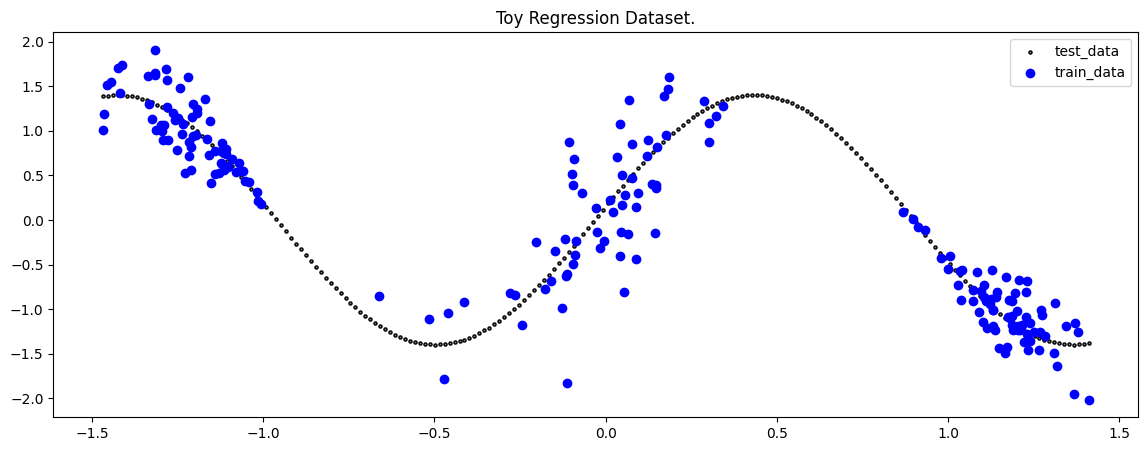

In [5]:
plot_toy_regression_data(X_train, y_train, X_test, y_test)

## Model

For our Toy Regression problem, we will use a simple Multi-layer Perceptron (MLP) that will be converted to a BNN as well as a Latent Variable Network.

In [6]:
bnn = MLP(n_inputs=1, n_hidden=[50, 50, 50], n_outputs=1, activation_fn=nn.Tanh())
latent_net = MLP(
    n_inputs=2,  # num_input_features + num_target_dim
    n_outputs=2,  # 2 * lv_latent_dim
    n_hidden=[20],
    activation_fn=nn.ReLU(),
)
bnn, latent_net

(MLP(
   (model): Sequential(
     (0): Linear(in_features=1, out_features=50, bias=True)
     (1): Tanh()
     (2): Dropout(p=0.0, inplace=False)
     (3): Linear(in_features=50, out_features=50, bias=True)
     (4): Tanh()
     (5): Dropout(p=0.0, inplace=False)
     (6): Linear(in_features=50, out_features=50, bias=True)
     (7): Tanh()
     (8): Dropout(p=0.0, inplace=False)
     (9): Linear(in_features=50, out_features=1, bias=True)
   )
 ),
 MLP(
   (model): Sequential(
     (0): Linear(in_features=2, out_features=20, bias=True)
     (1): ReLU()
     (2): Dropout(p=0.0, inplace=False)
     (3): Linear(in_features=20, out_features=2, bias=True)
   )
 ))

With an underlying neural network, we can now use our desired UQ-Method as a sort of wrapper. All UQ-Methods are implemented as [LightningModule](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html) that allow us to concisely organize the code and remove as much boilerplate code as possible.

In [7]:
bnn_vi_model = BNN_LV_VI_Batched_Regression(
    bnn,
    latent_net,
    optimizer=partial(torch.optim.Adam, lr=1e-3),
    num_training_points=X_train.shape[0],
    n_mc_samples_train=10,
    n_mc_samples_test=50,
    output_noise_scale=1.3,
    prior_mu=0.0,
    prior_sigma=1.0,
    posterior_mu_init=0.0,
    posterior_rho_init=-6.0,
    alpha=1e-03,
    bayesian_layer_type="reparameterization",
)

## Trainer

Now that we have a LightningDataModule and a UQ-Method as a LightningModule, we can conduct training with a [Lightning Trainer](https://lightning.ai/docs/pytorch/stable/common/trainer.html). It has tons of options to make your life easier, so we encourage you to check the documentation.

In [8]:
logger = CSVLogger(my_temp_dir)
trainer = Trainer(
    max_epochs=200,  # number of epochs we want to train
    logger=logger,  # log training metrics for later evaluation
    log_every_n_steps=1,
    enable_checkpointing=False,
    enable_progress_bar=False,
    limit_val_batches=0.0,  # skip validation runs
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training our model is now easy:

In [9]:
trainer.fit(bnn_vi_model, dm)

Missing logger folder: /tmp/tmp09rpu4bc/lightning_logs

  | Name               | Type                  | Params
-------------------------------------------------------------
0 | model              | MLP                   | 10.5 K
1 | train_metrics      | MetricCollection      | 0     
2 | val_metrics        | MetricCollection      | 0     
3 | test_metrics       | MetricCollection      | 0     
4 | energy_loss_module | EnergyAlphaDivergence | 0     
5 | prediction_head    | LinearVariational     | 102   
6 | lv_net             | LatentVariableNetwork | 102   
  | other params       | n/a                   | 1     
-------------------------------------------------------------
10.7 K    Trainable params
0         Non-trainable params
10.7 K    Total params
0.043     Total estimated model params size (MB)
/home/nils/.virtualenvs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a 

## Training Metrics

To get some insights into how the training went, we can use the utility function to plot the training loss and RMSE metric.

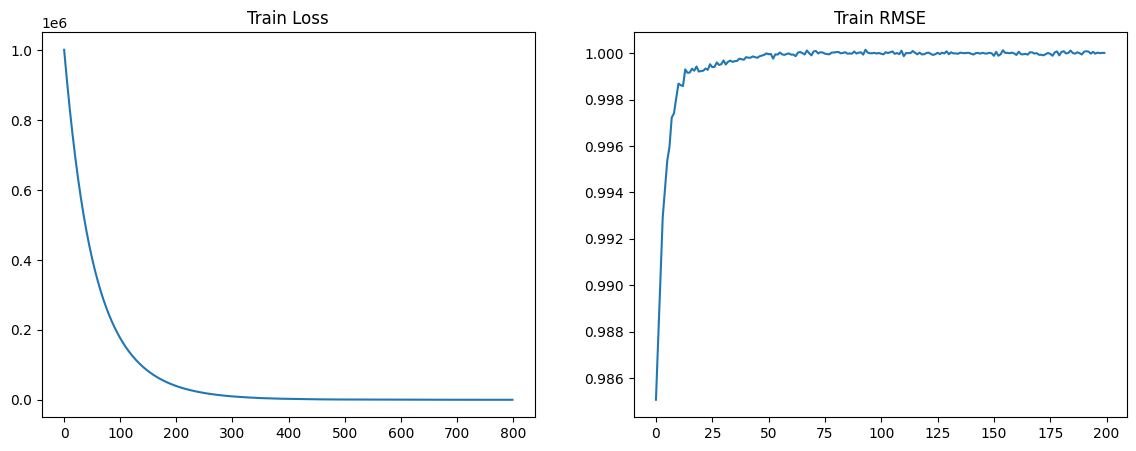

In [10]:
fig = plot_training_metrics(os.path.join(my_temp_dir, "lightning_logs"), "RMSE")

## Prediction

In [15]:
# save predictions
trainer.test(bnn_vi_model, dm)

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          testMAE          │    0.9086461663246155     │
│          testR2           │  -0.00041735172271728516  │
│         testRMSE          │    1.0064016580581665     │
└───────────────────────────┴───────────────────────────┘

[{'testMAE': 0.9086461663246155,
  'testR2': -0.00041735172271728516,
  'testRMSE': 1.0064016580581665}]

In [16]:
preds = bnn_vi_model.predict_step(X_test)

## Evaluate Predictions

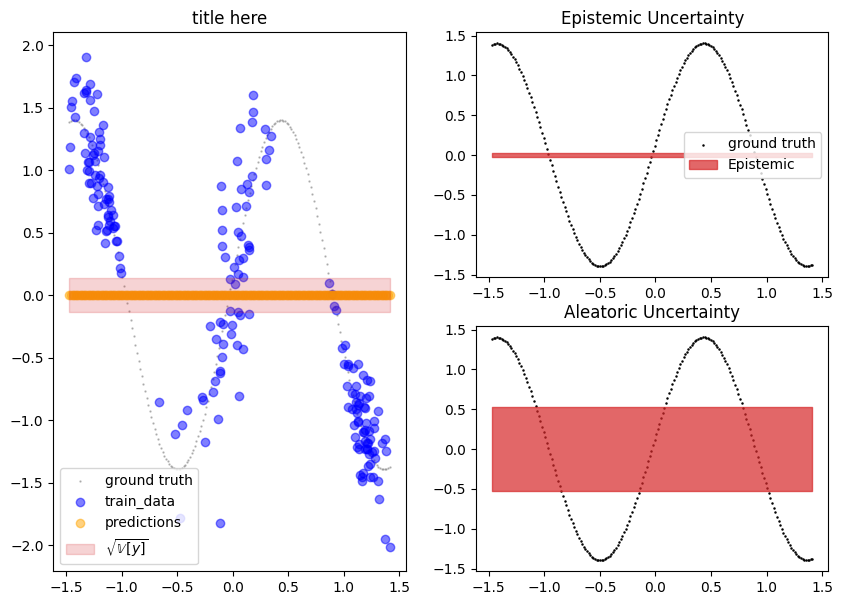

In [17]:
fig = plot_predictions_regression(
    X_train,
    y_train,
    X_test,
    y_test,
    preds["pred"],
    preds["pred_uct"],
    epistemic=preds["epistemic_uct"],
    aleatoric=preds["aleatoric_uct"],
    title="title here",
)

For some additional metrics relevant to UQ, we can use the great [uncertainty-toolbox](https://uncertainty-toolbox.github.io/) that gives us some insight into the calibration of our prediction.

<Figure size 1400x500 with 0 Axes>

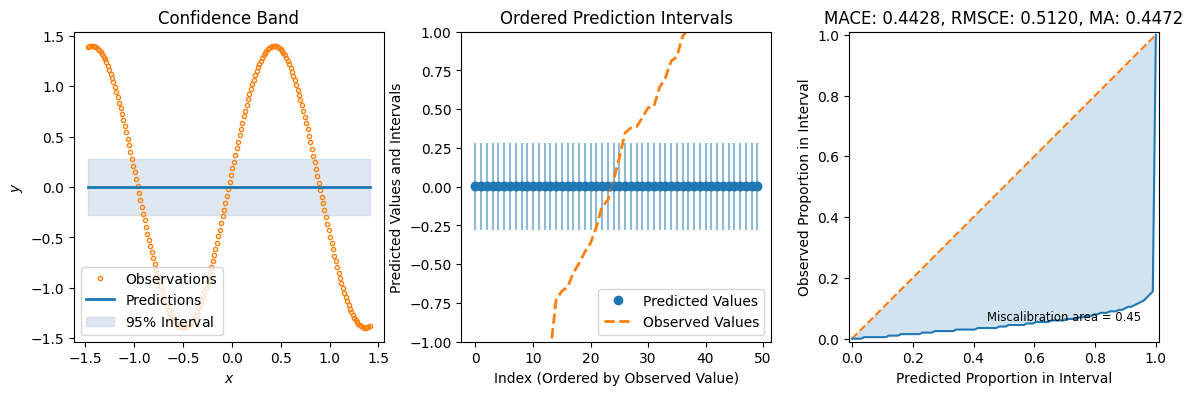

In [19]:
fig = plot_calibration_uq_toolbox(
    preds["pred"].numpy(), preds["pred_uct"], y_test.cpu().numpy(), X_test.cpu().numpy()
)

## Additional Resources

Links to othere related literature that might be interesting.